In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

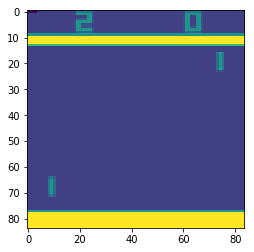

In [4]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

In [6]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)


In [7]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [8]:
class DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [ ]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 2000000
USE_CUDA = False
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "DQN_stackframe", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()

C:\Users\wxh20\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\wxh20\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0


frames:  1000, reward: -21.000000, loss: 0.000000, epsilon: 0.967544, episode:    1
frames:  2000, reward: -20.500000, loss: 0.000000, epsilon: 0.936152, episode:    2
frames:  3000, reward: -20.000000, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.250000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.200000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.333333, loss: 0.000000, epsilon: 0.820543, episode:    6
frames:  7000, reward: -20.285714, loss: 0.000000, epsilon: 0.793971, episode:    7
frames:  8000, reward: -20.222222, loss: 0.000000, epsilon: 0.768269, episode:    9
frames:  9000, reward: -20.200000, loss: 0.000000, epsilon: 0.743410, episode:   10
frames: 10000, reward: -20.200000, loss: 0.001245, epsilon: 0.719366, episode:   11
frames: 11000, reward: -20.300000, loss: 0.015207, epsilon: 0.696110, episode:   12
frames: 12000, reward: -20.500000, loss: 0.016642, epsilon: 0.673617, episod

frames: 98000, reward: -20.800000, loss: 0.000452, epsilon: 0.047752, episode:  111
frames: 99000, reward: -20.700000, loss: 0.002496, epsilon: 0.046514, episode:  112
frames: 100000, reward: -20.600000, loss: 0.008964, epsilon: 0.045317, episode:  113
frames: 101000, reward: -20.500000, loss: 0.003415, epsilon: 0.044159, episode:  114
frames: 102000, reward: -20.500000, loss: 0.004007, epsilon: 0.043040, episode:  115
frames: 103000, reward: -20.400000, loss: 0.001225, epsilon: 0.041956, episode:  116
frames: 104000, reward: -20.400000, loss: 0.005211, epsilon: 0.040909, episode:  117
frames: 105000, reward: -20.300000, loss: 0.000879, epsilon: 0.039895, episode:  118
frames: 106000, reward: -20.400000, loss: 0.002207, epsilon: 0.038915, episode:  120
frames: 107000, reward: -20.200000, loss: 0.001388, epsilon: 0.037967, episode:  121
frames: 108000, reward: -20.300000, loss: 0.002390, epsilon: 0.037050, episode:  122
frames: 109000, reward: -20.300000, loss: 0.002864, epsilon: 0.0361

frames: 194000, reward: -17.100000, loss: 0.007990, epsilon: 0.011539, episode:  178
frames: 195000, reward: -17.100000, loss: 0.002221, epsilon: 0.011488, episode:  179
frames: 196000, reward: -17.100000, loss: 0.001793, epsilon: 0.011440, episode:  179
frames: 197000, reward: -16.700000, loss: 0.004036, epsilon: 0.011392, episode:  180
frames: 198000, reward: -16.700000, loss: 0.001382, epsilon: 0.011347, episode:  180
frames: 199000, reward: -16.700000, loss: 0.000952, epsilon: 0.011303, episode:  180
frames: 200000, reward: -16.300000, loss: 0.003129, epsilon: 0.011260, episode:  181
frames: 201000, reward: -16.300000, loss: 0.004046, epsilon: 0.011219, episode:  181
frames: 202000, reward: -16.300000, loss: 0.001576, epsilon: 0.011179, episode:  181
frames: 203000, reward: -15.400000, loss: 0.001453, epsilon: 0.011140, episode:  182
frames: 204000, reward: -15.400000, loss: 0.002732, epsilon: 0.011103, episode:  182
frames: 205000, reward: -15.000000, loss: 0.001640, epsilon: 0.01

frames: 291000, reward: 9.500000, loss: 0.000828, epsilon: 0.010061, episode:  219
frames: 292000, reward: 10.200000, loss: 0.001176, epsilon: 0.010059, episode:  220
frames: 293000, reward: 10.200000, loss: 0.000623, epsilon: 0.010057, episode:  220
frames: 294000, reward: 10.200000, loss: 0.004566, epsilon: 0.010055, episode:  220
frames: 295000, reward: 9.500000, loss: 0.000843, epsilon: 0.010053, episode:  221
frames: 296000, reward: 9.500000, loss: 0.001914, epsilon: 0.010051, episode:  221
frames: 297000, reward: 8.200000, loss: 0.002742, epsilon: 0.010050, episode:  222
frames: 298000, reward: 8.200000, loss: 0.000944, epsilon: 0.010048, episode:  222
frames: 299000, reward: 9.800000, loss: 0.000496, epsilon: 0.010046, episode:  223
frames: 300000, reward: 9.800000, loss: 0.000670, epsilon: 0.010045, episode:  223
frames: 301000, reward: 9.800000, loss: 0.001513, epsilon: 0.010043, episode:  224
frames: 302000, reward: 9.800000, loss: 0.001168, epsilon: 0.010042, episode:  224
f

frames: 388000, reward: 16.300000, loss: 0.001164, epsilon: 0.010002, episode:  260
frames: 389000, reward: 16.400000, loss: 0.000550, epsilon: 0.010002, episode:  261
frames: 390000, reward: 16.400000, loss: 0.000950, epsilon: 0.010002, episode:  261
frames: 391000, reward: 16.400000, loss: 0.000297, epsilon: 0.010002, episode:  261
frames: 392000, reward: 16.700000, loss: 0.000941, epsilon: 0.010002, episode:  262
frames: 393000, reward: 16.700000, loss: 0.000534, epsilon: 0.010002, episode:  262
frames: 394000, reward: 16.300000, loss: 0.000831, epsilon: 0.010002, episode:  263
frames: 395000, reward: 16.300000, loss: 0.000444, epsilon: 0.010002, episode:  263
frames: 396000, reward: 16.300000, loss: 0.000486, epsilon: 0.010002, episode:  263
frames: 397000, reward: 15.800000, loss: 0.000484, epsilon: 0.010002, episode:  264
frames: 398000, reward: 15.800000, loss: 0.000732, epsilon: 0.010002, episode:  264
frames: 399000, reward: 15.800000, loss: 0.000753, epsilon: 0.010002, episod

In [ ]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

1. Establish a baseline performance. How well did your Deep Q-learning do on your problem? (5 Points)
total_episodes = 2000
tital_test_episodes = 200
max_steps = 2000000
learning rate = 2e-4
gamma = 0.99
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
eps_decay = 30000
2. What are the states, the actions, and the size of the Q-table? (5 Points)
The states are the position of the platform in the current frame. The actions are the platform moving up or down. The size og Q-table is the product of all the states and the actions.
3. What are the rewards? Why did you choose them? (5 Points)
A reward is awarded when the plaform catches the ball. Because the goal of the training is to make sure agent doesn't lose and wins by 21 goals.
4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?  (5 Points)
I'm trying to make the future more important, so I set the gamma at 0.99. Gamma usually has a value between 0 and 1, the smaller the value, the less far-sighted it is.
5. Try a policy other than maxQ(s', a'). How did it change the baseline performance? (5 Points)
The efficiency of training may decrease without affecting the final result. Because changing the policy only affects the current reward.
6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode? (5 Points)
The value of epsilon represents the exploration. When the number of steps reaches the maximum, epsilon is infinitely close to the minimum value of 0.01.
7. What is the average number of steps taken per episode? (5 Points)
1000
8. Does Q-learning use value-based or policy-based iteration? (5 Points)
Value-based. Because in Q-learning, we need to get every maxQ(s,a) value and using them as next basic value.
9. Could you use SARSA for this problem? (5 Points)
no. I don't fully understand this code yet. I just got a general idea of how SARSA works.
10. What is meant by the expected lifetime value in the Bellman equation?(5 Points)
In the bellman equation, the large the gamma value, the more focused on long-term returns.
11. When would SARSA likely do better than Q-learning? (5 Points)
SARSA avoids the cliffs in favor of a safer path. Q-learning might fall off a cliff in search of a locally optimal solution.
12. How does SARSA differ from Q-learning? (5 Points) 
SARSA avoids the cliffs in favor of a safer path. Q-learning might fall off a cliff in search of a locally optimal solution.
13. Explain the Q-learning algorithm. (5 Points)
Initialize Q(s,a) arbitrarily
Repeat(for each episode):
  Initialize s
  Repeat(for each step of episode):
   Choose a form s using policy derived from Q (e.g., epsilon-greedy)
   Take action a, observe r,s’
Q(s,a) <--Q(s,a)+alpha[r+gamma max(x) a’ Q(s’,a’)-Q(s,a)]
  s <- s’;
Until s is terminal
14. Explain the SARSA algorithm. (5 Points)  
Initialize Q(s,a) arbitrarily
Repeat(for each episode):
  Initialize s
  Repeat(for each step of episode):
   Choose a form s using policy derived from Q (e.g., epsilon-greedy)
   Take action a, observe r,s’
Q(s,a) <--Q(s,a)+alpha[r+gamma Q(s’,a’)-Q(s,a)]
  s <- s’; a<-a’
Until s is terminal

